In [22]:
from matplotlib.animation import FFMpegWriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from scipy import stats as st
from scipy.optimize import curve_fit
from scipy.stats import zscore
import cv2



class FatigueData:
    def __init__(self, name, file, threshold, window, type = 'DLC'):
        self.file = file
        self.name = name
        self.threshold = threshold
        self.window = window
        self.type = type
        self.data = self.loadData()

     
    def loadData(self):
        data = pd.read_csv(self.file, skiprows=3, header=None)

        def interpolate(df, x, y, likelihood, threshold):
            for i in range(1, len(df)):
                if df.iloc[i, likelihood] < threshold:
                    df.iloc[i, x] = df.iloc[i-1, x]
                    df.iloc[i, y] = df.iloc[i-1, y]

        #interpolate
        if self.type == 'DLC':
            step =1
        else:
            step = 3
        for i in range(step,len(data.columns),3):
            likelihood = i + 2  
            x_col = i  
            y_col = i + 1  
            interpolate(data, x_col, y_col, likelihood, self.threshold)

            #moving average
        for i in range(step, len(data.columns),3):
            x = data.columns[i]
            y = data.columns[i+1]
            data[x] = data[x].rolling(window=self.window, min_periods=1).mean()
            data[y] = data[y].rolling(window=self.window, min_periods=1).mean()        

        def calculate_angle(p3,p2, p1):
            #Calculate the angle at p2
            #Calculate the vectors
            v1 = np.array(p1) - np.array(p2)
            v2 = np.array(p3) - np.array(p2)
            #Calculate the angle
            angle = np.arccos(np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            z = p3[1] - p1[1]
            #Convert to degrees
            angle = np.degrees(angle)
            if z < 0:
                angle = 360 - angle
            return angle

        angle = []
        self.x = []
        self.y = []
        for i in range(len(data)):  #save angle for each posture for all frames
            if self.type == 'DLC':
                forearm = (data.iloc[i][data.columns[13]], data.iloc[i][data.columns[14]])
                wrist = (data.iloc[i][data.columns[10]], data.iloc[i][data.columns[11]])
                mcp = (data.iloc[i][data.columns[7]], data.iloc[i][data.columns[8]])
            else:
                forearm = (data.iloc[i][data.columns[15]], data.iloc[i][data.columns[16]])
                wrist = (data.iloc[i][data.columns[12]], data.iloc[i][data.columns[13]])
                mcp = (data.iloc[i][data.columns[9]], data.iloc[i][data.columns[10]])
            # pip = (data.iloc[i][data.columns[6]], data.iloc[i][data.columns[7]])
            # dip = (data.iloc[i][data.columns[3]], data.iloc[i][data.columns[4]])
            # Unpack the points into x and y coordinates
            self.x.append([forearm[0], wrist[0], mcp[0]])
            self.y.append([forearm[1], wrist[1], mcp[1]])
            angle.append(calculate_angle(forearm, wrist, mcp))
        # smoothed = uniform_filter1d(np.array(angle), size=self.window)
        return np.array(angle)
    
    def plotAll(self,height=130, prominence=10, width=10, window=10, distance=10, lim= (120,190)):

        self.peaks, _ = find_peaks(self.data, height=height, prominence=prominence, width=width, distance=distance)  
        self.valleys, _ = find_peaks(-self.data, height=-170, prominence=10, width=10)  
        
        # Plot the results
        plt.figure(figsize=(25, 5))
        plt.plot(self.data)
        plt.plot(self.peaks, self.data[self.peaks], "x", label='Peaks')
        plt.plot(self.valleys, self.data[self.valleys], "o", label='Valleys')
        # for peak in self.peaks:
        #     plt.axvline(x=peak-window, color='r', linestyle='--')
        #     plt.axvline(x=peak+window, color='b', linestyle='--')
        plt.title(f'{self.name} Fatigue Data')
        plt.xlabel('Frame')
        # plt.ylim(lim)
        plt.ylabel('Angle')
        plt.legend()
        plt.show()

    def stimPlot(self, stimNum, ax,sliceLength=150, start=2, c= 'r', label = ''):
        stim = self.peaks[stimNum]
        subset = self.data[stim-start:stim+sliceLength]
        # subset = uniform_filter1d(subset, size=4)
        # for i, angle in enumerate(subset):
        #     if angle < 0:
        #         subset[i] = 0
        # subset = subset / norm  #Set to stim 5 max value 
        # mean = self.angleChanges[stimNum]
        ax.plot(subset, color='black')
        # ax.plot( len(subset) // 2, mean, f'{c}o', label=f"Mean: {mean:.2f}")
        ax.set_title(f"Stim {self.filtered_indices[stimNum]+1}")
        # ax.axvline(x=stimStart, color='r', linestyle='--', alpha=0.5)
        # ax.axvline(x=stimEnd, color='r', linestyle='--', alpha=0.5)
        # ax.set_xlabel("Frame")
        ax.set_ylabel("Absolute Angle (degrees)")

    def getAngleChange(self,window, indices_shift=0, start_shift=0):
        angleChanges = []
        for i in range(len(self.peaks)):
            median = np.mean(self.data[self.peaks[i]-window:self.peaks[i]+window])
            angleChanges.append(median) # - self.data[self.valleys[-restIdx]])
        self.angleChanges = angleChanges

        means  = np.array(self.angleChanges)
        mask = ~np.isnan(means)
        filtered_means = means[mask]
        filtered_indices = np.arange(len(means))[mask]
        if start_shift != 0:
            filtered_indices[-start_shift:] += indices_shift
        self.filtered_means = filtered_means
        self.filtered_indices = filtered_indices


    def testAngleChange(self):
        peak_valley_differences = []
        peak_index = 0
        valley_index = 0
        plt.plot(self.data)
        while peak_index < len(self.peaks) and valley_index < len(self.valleys):
            if self.valleys[valley_index] < self.peaks[peak_index]:
                if peak_index == 0 or (valley_index > 0 and self.valleys[valley_index] > self.peaks[peak_index - 1]):
                    difference = self.data[self.peaks[peak_index]] - self.data[self.valleys[valley_index]]
                    # print(self.peaks[peak_index], self.valleys[valley_index], difference)
                    plt.axvline(x=self.peaks[peak_index], color='r', linestyle='--')
                    plt.axvline(x=self.valleys[valley_index], color='g', linestyle='--')
                    peak_valley_differences.append(difference)
                    peak_index += 1
                valley_index += 1
            else:
                peak_index += 1

        self.angleChanges = peak_valley_differences
    
    def fitExponentialDecay(self, guess, removeStartSlice = 0):

        # Fit exponential decay to means
        def exponential_decay(x, a, b, c):
            return a * np.exp(-b * x) + c
        
        def double_exponential_decay(x, a, b, c, d, e):
            return a*np.exp(-b*x) + c*np.exp(-d*x) + e

        # bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

        # popt1, pcov = curve_fit(double_exponential_decay, self.filtered_indices[removeStartSlice:], self.filtered_means[removeStartSlice:], maxfev=10000,p0=[1,0,5,0,160], bounds=bounds)
        # self.double_exponential = double_exponential_decay(self.filtered_indices, *popt1)

        bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
        
        popt, _ = curve_fit(exponential_decay, self.filtered_indices[removeStartSlice:], self.filtered_means[removeStartSlice:], maxfev=10000, p0=guess, bounds=bounds)
        self.exponential = exponential_decay(self.filtered_indices[removeStartSlice:], *popt)
        return popt
    
    def makeVideo(self, video_file, saveName,stimNum, start, sliceLength):

        stim = self.peaks[stimNum]
        startFrame = stim - start
        endFrame = stim + sliceLength

        # clipLength = n *30

        # Open the video
        cap = cv2.VideoCapture(video_file)
        if not cap.isOpened():
            print("Error opening video file")
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, startFrame)

        # Set up the writer object to write your video
        writer = FFMpegWriter(fps=30)

        # Create a figure for plotting
        fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

        # Prepare the video file to write to
        with writer.saving(fig, saveName, 100):
            i = startFrame

            while cap.isOpened() and i < endFrame:
                ret, frame = cap.read()
                if not ret:
                    break

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                ax.imshow(frame_rgb)
                ax.plot(self.x[i], self.y[i], marker='o', c='white')
                ax.axis('off')
                
                # Write the current frame to the video
                writer.grab_frame()
                ax.clear()

                i += 1

        # Release the video capture object and close the figure
        cap.release()
        plt.close(fig)


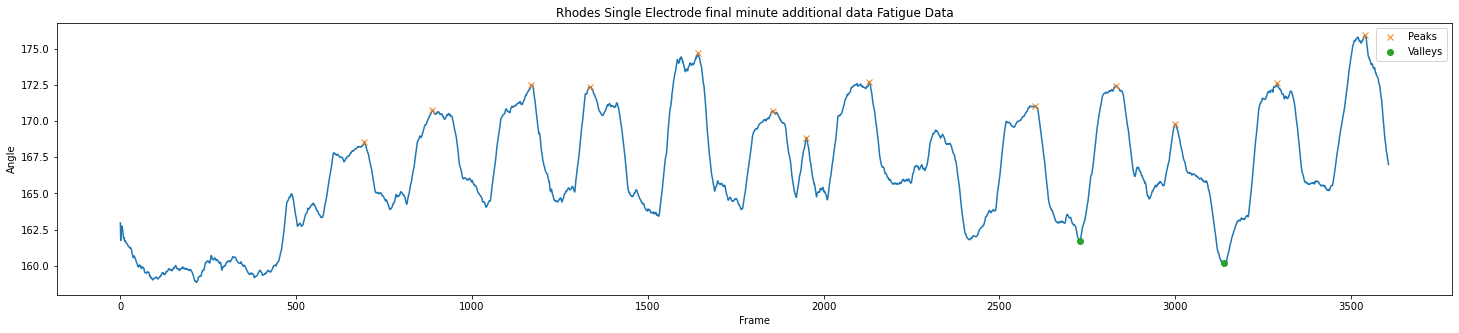

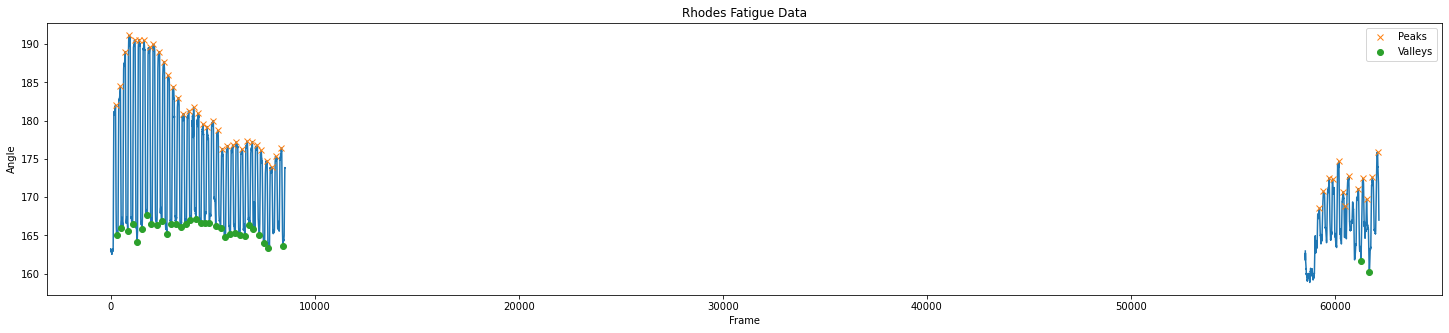

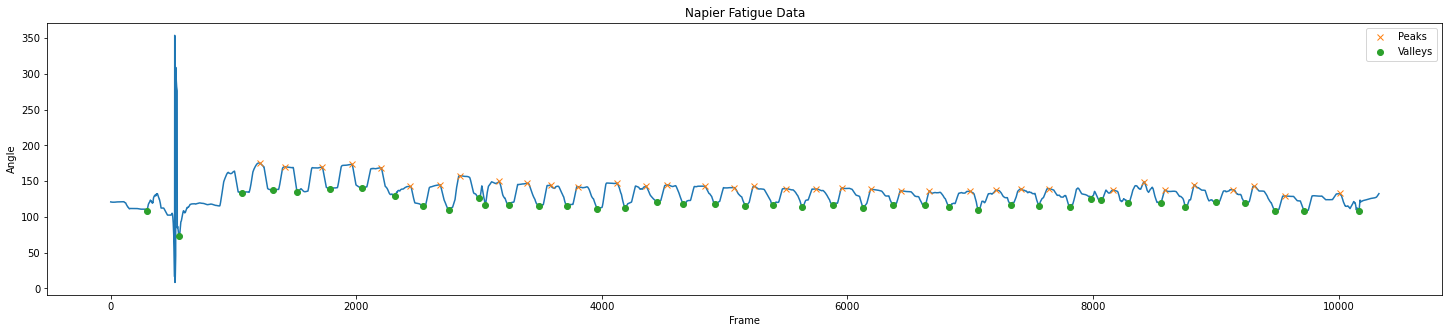

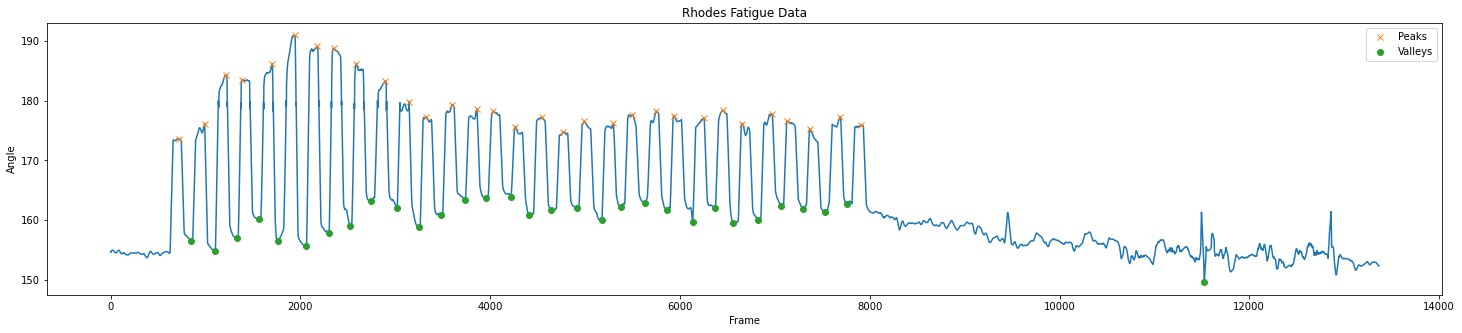

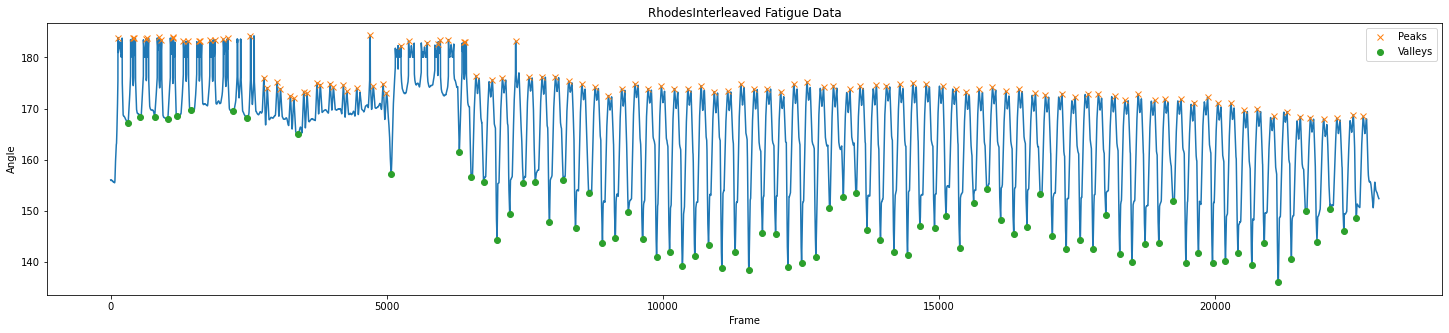

In [26]:
thresh = 0.5
window = 30
rhodes = FatigueData("Rhodes","/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/videos/rhodesfatigue_6_13_2024_2DLC_resnet50_FESFatigueMay31shuffle1_297000.csv", thresh, window, type='DLC')
# rhodes.plotAll(win  dow=50, distance=5)
# rhodessmol = FatigueData("Rhodes 2nd Motor Point",'/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/videos/rhodesfatigue2_6_13DLC_resnet50_FESFatigueMay31shuffle1_297000.csv', thresh, window, type='DLC')
# rhodessmol.plotAll(window=50, distance=5)
rhodesextra = FatigueData("Rhodes Single Electrode final minute additional data",'/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/videos/rhodesfatigueadditional_6_13DLC_resnet50_FESFatigueMay31shuffle1_297000.csv', thresh, window, type='DLC')
rhodesextra.plotAll(window=50, distance=10, prominence=4)
rhodes.data = np.concatenate((rhodes.data,[np.nan] * (27930+22080), rhodesextra.data))
rhodes.plotAll(window=50, distance=5,prominence=4)
napier = FatigueData("Napier","/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/videos/napierecrbfatigue_05_31_3_1DLC_resnet50_FESFatigueMay31shuffle1_37000.csv", 0.5, window)
napier.plotAll(window = 50, height=100, prominence=8, width=110, distance=2)
# rhodes = FatigueData("Rhodes","/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/videos/fatiguetest0523ecrb12_2DLC_resnet50_FESFatigueMay31shuffle1_37000.csv", 0.5, window)
# rhodes.plotAll(window = 50, height=130, prominence=10, width=110, distance=5)
rhodes2 = FatigueData("Rhodes","/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/videos/fatiguetest0523ecrb12_2DLC_resnet50_FESFatigueMay31shuffle1_297000.csv", 0.5, window)
rhodes2.plotAll(window = 50, height=130, prominence=10, width=110, distance=5)
rhodesinterleaved = FatigueData("RhodesInterleaved","/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/videos/ECRB_interleaved_stim_5_30_1DLC_resnet50_FESFatigueMay31shuffle1_37000.csv", thresh, window)
rhodesinterleaved.plotAll(window = 50, height=130, prominence=4, width=20, distance=5)

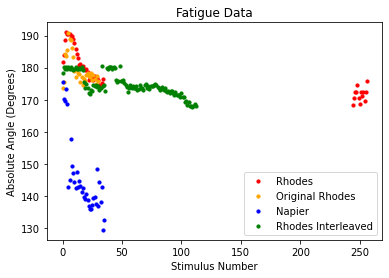

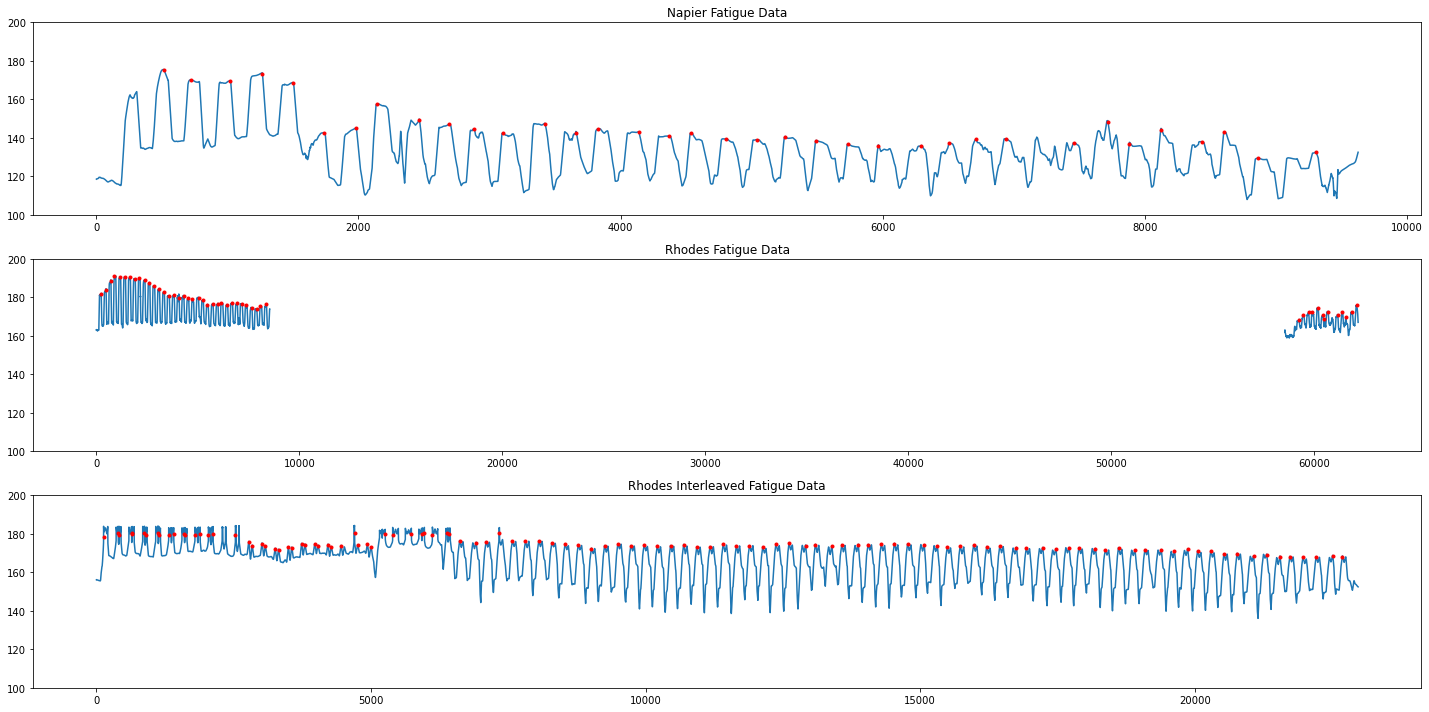

In [27]:
rhodes.getAngleChange(5,start_shift=13, indices_shift=209)
napier.getAngleChange(5)
rhodesinterleaved.getAngleChange(5)
rhodesextra.getAngleChange(5)
rhodes2.getAngleChange(5)

# shift = len(rhodesextra.angleChanges)

plt.figure()
plt.scatter(rhodes.filtered_indices, rhodes.angleChanges, label='Rhodes', color='r', s=10)
plt.scatter(rhodes2.filtered_indices, rhodes2.angleChanges, label='Original Rhodes', color='orange', s=10)
# plt.scatter(np.arange(len(rhodesextra.angleChanges))+209, rhodesextra.angleChanges, color='r')
plt.scatter(napier.filtered_indices, napier.angleChanges, label='Napier', color='b', s=10)
plt.scatter(rhodesinterleaved.filtered_indices, rhodesinterleaved.angleChanges, label='Rhodes Interleaved', color='g', s=10)
plt.xlabel("Stimulus Number")
plt.ylabel("Absolute Angle (Degrees)")
plt.title(f'Fatigue Data')
plt.legend()

fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharey=True, )  # Add sharex=True
plt.ylim(100, 200)

# Plot for napier
axs[0].plot(napier.data[700:])
axs[0].plot(napier.peaks-700, napier.angleChanges, ".r", label='Peaks')
axs[0].set_title('Napier Fatigue Data')

# Plot for rhodes
axs[1].plot(rhodes.data)
axs[1].plot(rhodes.peaks, rhodes.angleChanges, ".r", label='Peaks')
axs[1].set_title('Rhodes Fatigue Data')

# Plot for rhodesinterleaved
axs[2].plot(rhodesinterleaved.data)
axs[2].plot(rhodesinterleaved.peaks, rhodesinterleaved.angleChanges, ".r", label='Peaks')
axs[2].set_title('Rhodes Interleaved Fatigue Data')

plt.tight_layout()
plt.show()

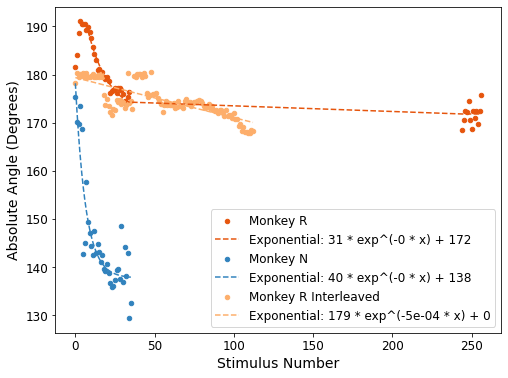

In [36]:

# rhodes.filtered_means = np.concatenate((rhodes.filtered_means, rhodes2.filtered_means))
# rhodes.filtered_indices = np.concatenate((rhodes.filtered_indices, rhodes2.filtered_indices))

# sorted_indices = np.argsort(rhodes.filtered_indices)
# rhodes.filtered_indices = rhodes.filtered_indices[sorted_indices]
# rhodes.filtered_means= rhodes.filtered_means[sorted_indices]


guess = [2,2,160]
popT = rhodes.fitExponentialDecay(guess, removeStartSlice=8)
popT2 = napier.fitExponentialDecay(guess)
popT3 = rhodesinterleaved.fitExponentialDecay(guess)


plt.figure(figsize=(8, 6))
plt.scatter(rhodes.filtered_indices, rhodes.filtered_means, label='Monkey R', color='#e6550d', s=20)

#Slicing this plot since we didn't include the first 8 values in the fit
plt.plot(rhodes.filtered_indices[8:], rhodes.exponential, label=f'Exponential: {popT[0]:.0f} * exp^(-{popT[1]:.0f} * x) + {popT[2]:.0f}', color='#e6550d', linestyle='--')

plt.scatter(napier.filtered_indices, napier.angleChanges, label='Monkey N', color='#3182bd', s=20)
plt.plot(napier.exponential, label=f'Exponential: {popT2[0]:.0f} * exp^(-{popT2[1]:.0f} * x) + {popT2[2]:.0f}', color='#3182bd', linestyle='--')

plt.scatter(rhodesinterleaved.filtered_indices, rhodesinterleaved.angleChanges, label='Monkey R Interleaved', color='#fdae6b', s=20)
plt.plot(rhodesinterleaved.exponential, label=f'Exponential: {popT3[0]:.0f} * exp^(-{popT3[1]:.0e} * x) + {popT3[2]:.0f}', color='#fdae6b', linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Stimulus Number", fontsize=14)
plt.ylabel("Absolute Angle (Degrees)", fontsize=14)
plt.legend(loc='lower right', fontsize=12)
# plt.yscale('log')
plt.show()


In [ ]:
rhodes.makeVideo( )

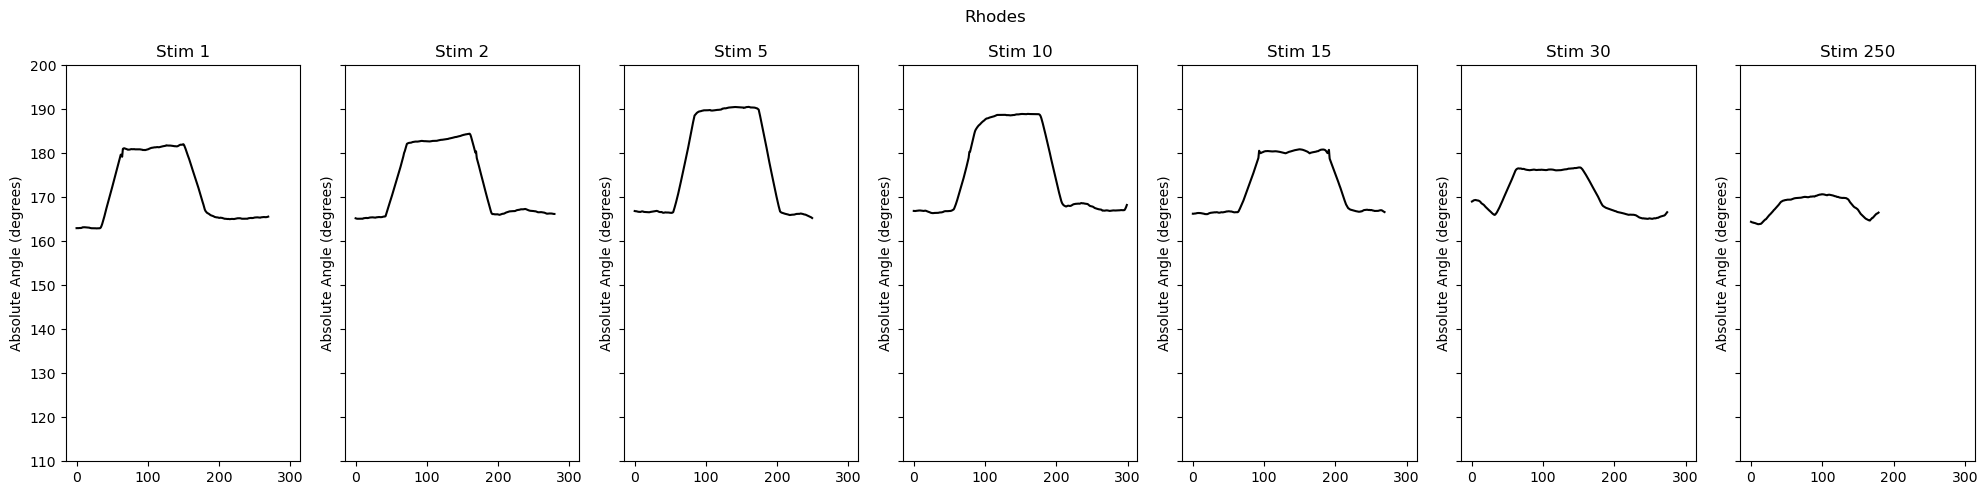

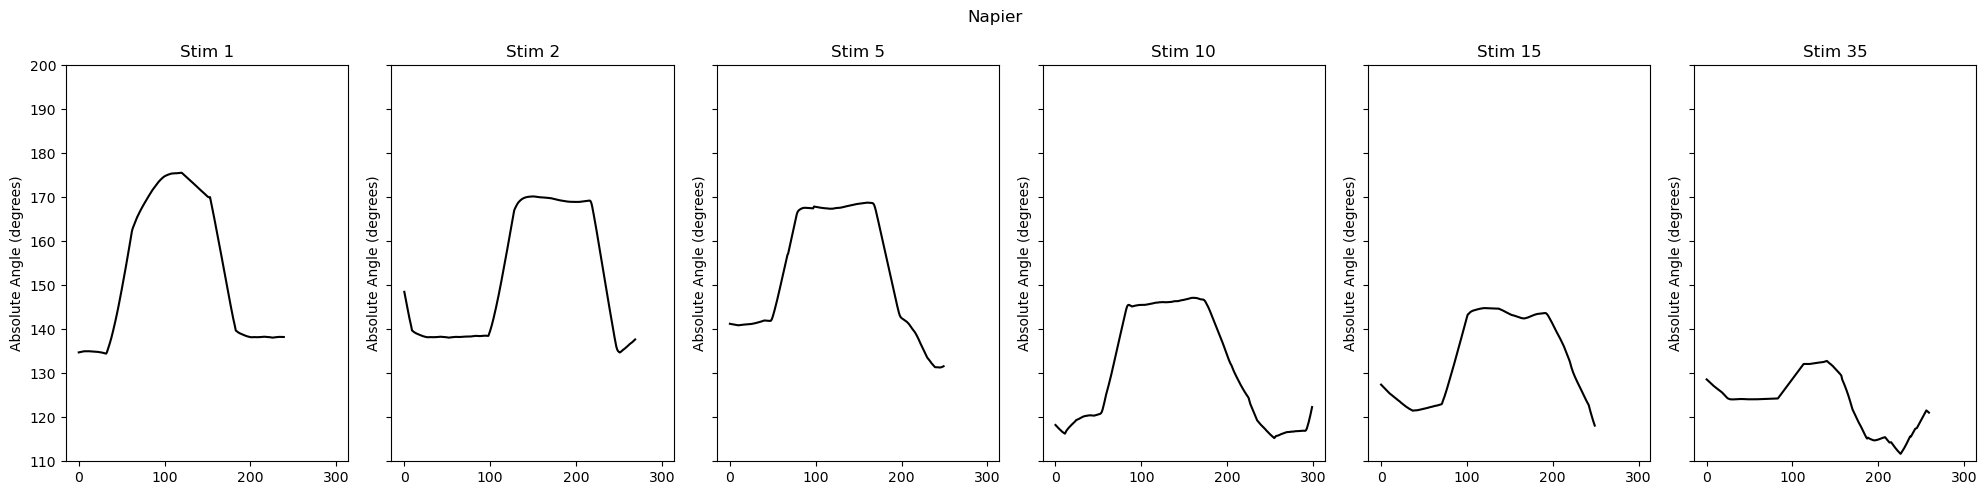

In [493]:
# # Create subplots
fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)

axes = axes.flatten()

stimuli = [0, 1, 4, 9, 14, 29, 40]
# lengths = [120, 120, 90, 150, 120, 120]
# starts = [100, 160, 160, 160, 130, 140]

#Rhodes
lengths = [120, 120, 90, 140, 120, 125,80]
starts = [150, 160, 160, 160, 150, 150,100]


for i, (stim, length, start) in enumerate(zip(stimuli, lengths, starts)):
    rhodes.stimPlot(stim, axes[i], length, start, 'r',)
    axes[i].set_ylim(110, 200)  # Set the y-axis limit to 0 and 100

plt.suptitle('Rhodes')
plt.ylabel('Absolute Angle (degrees)')
plt.tight_layout()
fig.savefig('Rhodes.svg', format='svg')
plt.show()

stimuli = [0, 1, 4, 9, 14, 34]
lengths = [120, 120, 90, 140, 130, 120]
starts = [120, 150, 160, 160, 120, 140]

# # Create subplots
fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharex=True, sharey=True)

axes = axes.flatten()

for i, (stim, length, start) in enumerate(zip(stimuli, lengths, starts)):
    napier.stimPlot(stim, axes[i], length, start, 'r',)
    axes[i].set_ylim(110, 200)  # Set the y-axis limit to 0 and 100

plt.suptitle('Napier')
plt.ylabel('Absolute Angle (degrees)')
plt.tight_layout()
fig.savefig('Napier.svg', format='svg')
plt.show()



In [ ]:
# rhodes.getAngleChange(2)
# napier.getAngleChange(1)
# rhodesinterleaved.getAngleChange(1)
plt.figure(figsize=(30, 6))
rhodes.testAngleChange()
plt.figure(figsize=(30, 6))
napier.testAngleChange()
plt.figure(figsize=(30, 6))
rhodesinterleaved.testAngleChange()
plt.figure()
plt.scatter(np.arange(len(rhodes.angleChanges)), rhodes.angleChanges, label='Rhodes')
plt.scatter(np.arange(len(napier.angleChanges)), napier.angleChanges, label='Napier')
plt.scatter(np.arange(len(rhodesinterleaved.angleChanges)), rhodesinterleaved.angleChanges, label='Rhodes Interleaved')
plt.xlabel("Stimulus Number")
plt.ylabel("Mean Change in Angle (Degrees)")
plt.title(f'Fatigue Data')
plt.legend()
